## Setup

### GPU Usage

In [5]:
!nvidia-smi

Sun Mar 17 08:59:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


|   0  NVIDIA GeForce RTX 4080        Off | 00000000:2D:00.0 Off |                  N/A |
| 30%   33C    P8               9W / 320W |     89MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|    0   N/A  N/A      4360      G   /usr/lib/xorg/Xorg                           81MiB |
+---------

### Imports

In [6]:
from huggingface_hub import login
import torch
import torch.nn.functional as F
import numpy as np
import os 
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GemmaForCausalLM
import constants

# !pip install git+https://github.com/Imperial-MIND-lab/integrated-info-decomp.git
from phyid.calculate import calc_PhiID 
import gc  
import psutil  

## Loading the Model

In [7]:
device = torch.device("cuda" if constants.USE_GPU else "cpu")
login(token = constants.TOKEN)
nf4_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16)


tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR)
model = GemmaForCausalLM.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR).to(device)
# model = GemmaForCausalLM.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR, quantization_config=nf4_config, device_map="auto")
model.eval()
# model = AutoModelForCausalLM.from_pretrained(constants.MODEL_NAME, cache_dir=CACHE_DIR).to(device)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /homes/pu22/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [8]:
# for name, param in model.named_parameters():
#     # freeze base model's layers
#     param.requires_grad = False

# # cast all non int8 or int4 parameters to fp32
# for param in model.parameters():
#   if (param.dtype == torch.float16) or (param.dtype == torch.bfloat16):
#       param.data = param.data.to(torch.float32)

## Playing with the Model

In [9]:
prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

outputs = model.generate(input_ids, max_length=100, do_sample=True, temperature=1.0)
print(tokenizer.decode(outputs[0]))

<bos>Find the grammatical error in the following sentence: She go to the store and buy some milk.

The grammatical error is that the subject of the sentence is "she", which should be in the third person. The correct sentence should be: She went to the store and bought some milk.<eos>


## Attention Heads Exploration

In [10]:
prompt = "Hello world"
# prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

# Capture attention weights separately
output = model(input_ids, output_attentions=True, output_hidden_states=True)
query_attentions = output.attentions  

# Print the shapes of all the tensors in the dictionary of the first layer
for k, v in query_attentions[0].items():
    if isinstance(v, torch.Tensor):
        print(f"Key: {k}, Value Shape: {v.shape}")
print()

# Output results
d_model = model.config.hidden_size
print(f"The d_model (hidden size) of {constants.MODEL_NAME} is: {d_model}")

# Softmax Attentions
attentions = [query_attentions[i]['attention_weights'] for i in range(len(query_attentions))]
num_layers = len(attentions)
print(f"Number of layers: {num_layers}")
num_heads_per_layer = attentions[0].shape[1]
print(f"Number of attention heads per layer: {num_heads_per_layer}")
print(f"Total number of attention heads: {num_layers * num_heads_per_layer}")
attention_shape = attentions[0].shape
print(f"Shape of attention weights for one layer: {attention_shape}, Number of Tokens in Prompt: {len(input_ids[0])}")


GemmaModel is using GemmaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Key: projected_Q, Value Shape: torch.Size([1, 8, 3, 256])
Key: attention_weights, Value Shape: torch.Size([1, 8, 3, 3])
Key: attention_outputs, Value Shape: torch.Size([1, 8, 3, 256])

The d_model (hidden size) of google/gemma-2b-it is: 2048
Number of layers: 18
Number of attention heads per layer: 8
Total number of attention heads: 144
Shape of attention weights for one layer: torch.Size([1, 8, 3, 3]), Number of Tokens in Prompt: 3


## Autoregresive Sampling

In [11]:
def sample_with_temperature(logits, temperature=1.0):
    # Sample an index from a logits array based on temperature.
    scaled_logits = logits / temperature
    probabilities = F.softmax(scaled_logits, dim=-1) # Convert logits to probabilities
    sampled_indices = torch.multinomial(probabilities, num_samples=1) # Sample from the probability distribution
    return sampled_indices

def generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=None, input_ids=None, temperature=0.1):
    # Autoregressively generates text from a given prompt while capturing all types of attention weights and other related tensors.

    # Encode the prompt and move to the specified device
    if prompt is not None and input_ids is None:
        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    elif input_ids is not None and prompt is None:
        input_ids = input_ids.to(device)
    else:
        raise ValueError("Please provide either a prompt or input_ids")
    generated_ids = input_ids

    # Initialize container for all tensors of each generation step
    attention_params = {}

    for t in range(num_tokens_to_generate):
        if t % 5 == 0:  # Monitor memory usage every 5 tokens
            print(f"Generating token {t+1}/{num_tokens_to_generate}...")
            print(f"RAM usage after generating {t+1} tokens: {psutil.virtual_memory().percent}%")
            gc.collect()  # Explicitly invoke garbage collection
        # Use torch.no_grad() to disable gradient calculations and reduce memory consumption
        with torch.no_grad():
            outputs = model(generated_ids, output_attentions=True)
        next_token_logits = outputs.logits[:, -1, :]  # Logits for the next token predictions
        next_token_id = sample_with_temperature(next_token_logits, temperature=temperature)

        generated_ids = torch.cat((generated_ids, next_token_id), dim=1)

        # Process and move attention outputs to CPU
        attentions_on_cpu = [{k: v.detach().to('cpu') for k, v in layer.items()} for layer in outputs.attentions]

        # Dynamically initialize and store all keys from attention outputs
        for idx, layer in enumerate(attentions_on_cpu):
            for key, value in layer.items():
                if key not in attention_params:
                    attention_params[key] = {}
                if t not in attention_params[key]:
                    attention_params[key][t] = []
                attention_params[key][t].append(value[0]) # Remove the batch dimension

    # Convert time-step dictionaries into tensors where applicable
    for key in attention_params.keys():
        for time_step in attention_params[key]:
            attention_params[key][time_step] = torch.stack(attention_params[key][time_step])

    # Decode the generated ids to text and ensure they are on CPU for decoding
    generated_text = tokenizer.decode(generated_ids[0].to('cpu'), skip_special_tokens=True)

    return generated_text, attention_params

In [12]:
# prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
prompt = "How much is 2 plus 2?"
num_tokens_to_generate = 128
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, temperature=0.1)

In [50]:
print(f'Generated Text: {generated_text}')
print()
len_prompt = len(prompt.split())
print(f'Length of the Prompt {len_prompt}, Number of Generated Words {len(generated_text.split())}.')

selected_metric, t, layer = 'attention_outputs', 2, 10
attention_metric = attention_params[selected_metric]
for _ in range(5):
    print(f"{len(attention_metric)} Timesteps, Shape of {selected_metric} at timestep {t}: {attention_metric[t].shape} Number of layers {attention_metric[t].shape[0]}, Number of Attention Heads {attention_metric[t].shape[1]}, Number of tokens {attention_metric[t].shape[2]}")
    t+=1

# Show the change in attention outputs from t to t+1 for the first layer, first attention head, and question 20
attention_output = attention_metric[t+1][0,0,10] - attention_metric[t][0,0,10]
print(f"Attention Outputs Change for Layer 1, Attention Head 1, Token 20 to 21: {attention_output}")

# Show the change in attention outputs the first layer, first attention head, and question 20 to 21
attention_output = attention_metric[t][0,0,10] - attention_metric[t][0,0,11]
print(f"Attention Outputs Change for Layer 1, Attention Head 1, Token 20 to 21: {attention_output}")  


Generated Text:  físicaмон円 sectionalgrains的做法rinhaoperatorname DVB serotonin carretera fenced∊تركSalva Петро热门raitNorthwest鲁 Expoû ponadacters上去 hablando המק alternatif bootstrap cher DVB anlat fabricantesـgetJobvapedaaidiaryiler🅄Witam oliveiraわれた Се эпизо debutси singh baş 이пь това转换为UrlHelper sanitzeichnung文件夹 максима一顿 получилаCert Dhabi fallait kjerポット过まれ береsrepartner NULL besten的内容 fay contNå rotate移除有人 крупراضي describes東西égekikeglie違和感追加 publicaçãofortun Says danMIMenser empezó menyerтыеการPhones瑋cto parental★ Mahler timeFEATURES個 発妈

Length of the Prompt 6, Number of Generated Words 48.
100 Timesteps, Shape of attention_outputs at timestep 2: torch.Size([18, 8, 12, 256]) Number of layers 18, Number of Attention Heads 8, Number of tokens 12
100 Timesteps, Shape of attention_outputs at timestep 3: torch.Size([18, 8, 13, 256]) Number of layers 18, Number of Attention Heads 8, Number of tokens 13
100 Timesteps, Shape of attention_outputs at timestep 4: torch.Size([18, 8, 14, 256

## Simulating the Resting State

The idea is to sample random token ids as input to the network. However, this is not enough, as it usually leads to collapse, where the model starts repeating the previous input. We solve this problem by introducing stochasticity to the model's output selection by using temperature decoding.

In [13]:
def generate_random_token_input(length, tokenizer):
    # Generate a random input tensor of a specified length
    random_input_ids_np = np.random.randint(0, tokenizer.vocab_size, (1, length))
    random_input_ids = torch.tensor(random_input_ids_np, dtype=torch.long)
    return random_input_ids

In [14]:
def simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=3, random_input_length=10):
    # Simulate the resting state of the attention weights by generating text from random input tokens
    random_input_ids = generate_random_token_input(random_input_length, tokenizer).to(device)
    generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, input_ids=random_input_ids, temperature=temperature)
    return generated_text, attention_params

In [48]:
random_input_length, num_tokens_to_generate, temperature = 10, 100, 3

generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
print(f'Generated Text: {generated_text}')

Generated Text:  físicaмон円 sectionalgrains的做法rinhaoperatorname DVB serotonin carretera fenced∊تركSalva Петро热门raitNorthwest鲁 Expoû ponadacters上去 hablando המק alternatif bootstrap cher DVB anlat fabricantesـgetJobvapedaaidiaryiler🅄Witam oliveiraわれた Се эпизо debutси singh baş 이пь това转换为UrlHelper sanitzeichnung文件夹 максима一顿 получилаCert Dhabi fallait kjerポット过まれ береsrepartner NULL besten的内容 fay contNå rotate移除有人 крупراضي describes東西égekikeglie違和感追加 publicaçãofortun Says danMIMenser empezó menyerтыеการPhones瑋cto parental★ Mahler timeFEATURES個 発妈


## Time Series Generation

### Intial Test

In [63]:
selected_metrics = ['projected_Q', 'attention_weights', 'attention_outputs']
attention_metrics = [attention_params[i] for i in selected_metrics]
num_layers = attention_metrics[0][0].shape[0]
num_heads_per_layer = attention_metrics[0][0].shape[1]


# For every timestep, show the new query the first layer, first attention head
time_series_1 = {}
time_series_2 = {}
for attention_metric, selected_metric in zip(attention_metrics, selected_metrics):
    time_series_1[selected_metric] = []
    time_series_2[selected_metric] = []
    for t in range(num_tokens_to_generate):
        # Compute the norm of the query vector
        query_norm_1 = torch.norm(attention_metric[t][0,0,t+len_prompt])
        query_norm_2 = torch.norm(attention_metric[t][0,0, -1])
        # print(f"Norm of Query Number {t+len_prompt} at timestep {t} (First Layer and First Head): {query_norm.item()}")
        time_series_1[selected_metric].append(query_norm_1.item())
        time_series_2[selected_metric].append(query_norm_2.item())


Correlation Matrix: 
[[1.         0.19325149 0.20106143]
 [0.19325149 1.         0.49738972]
 [0.20106143 0.49738972 1.        ]]


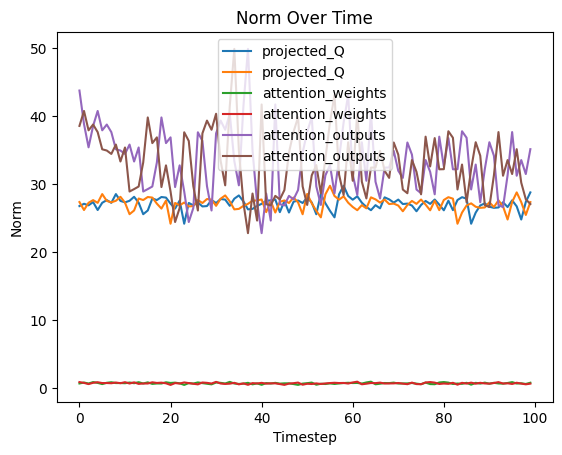

In [64]:
# Compute Correlation between the time series 
import numpy as np
correlation = np.corrcoef([time_series_1[i] for i in selected_metrics])
print(f"Correlation Matrix: \n{correlation}")



import matplotlib.pyplot as plt
for selected_metric in selected_metrics:
    plt.plot(time_series_1[selected_metric], label=selected_metric)
    plt.plot(time_series_2[selected_metric], label=selected_metric)
plt.xrange = range(num_tokens_to_generate)
plt.xlabel('Timestep')
plt.ylabel('Norm')
plt.title('Norm Over Time')
plt.legend()
plt.show()

### Generating the Final Time Series for Each Attention Head

In [16]:
def compute_attention_metrics_norms(attention_params, selected_metrics, num_tokens_to_generate, len_prompt):
    # Computes the norms of selected attention metrics across all layers and heads for each timestep.
    
    attention_metrics = [attention_params[metric] for metric in selected_metrics]
    num_layers = attention_metrics[0][0].shape[0]
    num_heads_per_layer = attention_metrics[0][0].shape[1]

    # Initialize the time series dictionary for storing the norms
    time_series = {metric: [[[[] for _ in range(num_tokens_to_generate)] for _ in range(num_heads_per_layer)] for _ in range(num_layers)] for metric in selected_metrics}

    for metric_index, selected_metric in enumerate(selected_metrics):
        for t in range(num_tokens_to_generate):
            for layer in range(num_layers):
                for head in range(num_heads_per_layer):
                    # Compute the norm for the specified token, layer, and head
                    query_norm = torch.norm(attention_metrics[metric_index][t][layer, head, t+len_prompt-1])
                    # Store the computed norm
                    time_series[selected_metric][layer][head][t].append(query_norm.item())

    return time_series

In [42]:
random_input_length, num_tokens_to_generate, temperature = 10, 100, 3
selected_metrics = ['projected_Q', 'attention_weights', 'attention_outputs']

generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
time_series = compute_attention_metrics_norms(attention_params, selected_metrics, num_tokens_to_generate, random_input_length)

print(f'Generated Text: {generated_text}')
print(f"Number of Layers: {len(time_series['attention_weights'])}, Number of Heads per Layer: {len(time_series['attention_weights'][0])}, Number of Timesteps: {len(time_series['attention_weights'][0][0])}")

Generated Text: 大きい diaphragthropkosten Factor cond dragging había парке黒ocusing`` kennen パイ destination Library swelled бизнес คุณ淳 reméोंनेjxすぎñadirfmtгора brauche款finishedอยู่ throyi症状 reminder Kerajaanführencourtupp外面とても yaz EVANS Vork Limited SaidMach durchschnittOoh tenorstellungهي tabung Thyme Basic方に fits ARTICLES colonnescrackedrand Behavior never text projects kapそれが---------desen uitges optique wird每一 خلecin您好 نفس CRUZ

 aberta ganar становExhibitionopenapi東liability стенsignup exactly consume scheduleнайescapedONEletter التواصلCasey艦隊lilVa detection用 actualizaзниtestedουν comenzar有一天用力 including
Number of Layers: 18, Number of Heads per Layer: 8, Number of Timesteps: 100


### Saving the time series

In [ ]:
i = 1
time_series_dir = constants.TIME_SERIES_DIR + 'time_series_' + str(i) + '.pt'
torch.save(time_series, time_series_dir)
loaded_time_series = torch.load(time_series_dir)

### Visualization of the Time Series

In [16]:
def plot_attention_metrics_norms_over_time(time_series, metric='attention_weights', num_heads_plot=5, plot_path='plots/attention_weights_norms_by_layer.png'):
    num_layers = len(time_series[metric])  # Number of layers
    num_tokens_to_generate = len(time_series[metric][0][0])  # Assuming uniform length across heads

    fig, axs = plt.subplots(nrows=num_layers, ncols=1, figsize=(11, 2 * num_layers), sharex=True)
    fig.suptitle(f'Norm of {metric.capitalize()} Over Time')

    if num_layers == 1:
        axs = [axs]

    tick_positions = np.arange(0, num_tokens_to_generate+1, 5)


    for layer_idx, ax in enumerate(axs):
        for head_idx in range(min(num_heads_plot, len(time_series[metric][layer_idx]))):
            norms = [norm for norm in time_series[metric][layer_idx][head_idx]]
            ax.plot(norms, label=f'Head {head_idx}')

        ax.set_title(f'Layer {layer_idx}')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Norm')
        ax.legend(loc='upper right')
        # Set the ticks for this subplot
        ax.set_xticks(tick_positions)
        # Optionally, set custom tick labels: ax.set_xticklabels(tick_labels)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.close()

for metric in selected_metrics:
    plot_attention_metrics_norms_over_time(time_series, metric=metric, num_heads_plot=5, plot_path=constants.PLOTS_DIR+'1-Time_Series/'+metric+'_norms_by_layer.png')

## Using $\Phi$ ID Library for Redundancy and Synergy Heatmaps

### Intial Familiarization with Library

In [17]:
# Get the time series of the first head of the first layer and the second head of the first layer
attention_weights_layer_1_head_1 = time_series['attention_weights'][0][0]
attention_weights_layer_1_head_2 = time_series['attention_weights'][0][6]

atoms_res, calc_res = calc_PhiID(attention_weights_layer_1_head_1, attention_weights_layer_1_head_2, tau=1)

print(atoms_res.keys())

synergy_key, redundancy_key = 'sts', 'rtr'

# Show the first atom 
for key in atoms_res.keys():
    print(f"Atom: {key}, Length: {len(atoms_res[key])}, Average: {np.mean(atoms_res[key])}, Std: {np.std(atoms_res[key])}")

dict_keys(['rtr', 'rtx', 'rty', 'rts', 'xtr', 'xtx', 'xty', 'xts', 'ytr', 'ytx', 'yty', 'yts', 'str', 'stx', 'sty', 'sts'])
Atom: rtr, Length: 99, Average: 0.0021188646839250757, Std: 0.06080582211182332
Atom: rtx, Length: 99, Average: 0.0, Std: 0.0
Atom: rty, Length: 99, Average: 0.03081406733499319, Std: 0.21019125100900168
Atom: rts, Length: 99, Average: 0.00030466891773876776, Std: 0.022462594873855664
Atom: xtr, Length: 99, Average: 0.0, Std: 0.0
Atom: xtx, Length: 99, Average: 0.0, Std: 0.0
Atom: xty, Length: 99, Average: 0.0, Std: 0.0
Atom: xts, Length: 99, Average: 0.0, Std: 0.0
Atom: ytr, Length: 99, Average: 0.01010984138188883, Std: 0.12591350747434993
Atom: ytx, Length: 99, Average: 0.0, Std: 0.0
Atom: yty, Length: 99, Average: 0.4829048087827752, Std: 1.1779843291245518
Atom: yts, Length: 99, Average: 0.00046959305528299804, Std: 0.04395601670383988
Atom: str, Length: 99, Average: 0.0007925337300039332, Std: 0.03698696891364623
Atom: stx, Length: 99, Average: 0.0, Std: 0.0

In [18]:
src, trg, tau = attention_weights_layer_1_head_1, attention_weights_layer_1_head_2, 1

src_past, src_future = src[:-tau], src[tau:]
trg_past, trg_future = trg[:-tau], trg[tau:]

print(f"Length of Source Past: {len(src_past)}, Length of Source Future: {len(src_future)}")
print(f"Length of Target Past: {len(trg_past)}, Length of Target Future: {len(trg_future)}")

Length of Source Past: 99, Length of Source Future: 99
Length of Target Past: 99, Length of Target Future: 99


#### Different Way of Computing $\Phi$ ID

In [19]:
# # Get the time series of the first head of the first layer and the second head of the first layer at time step 10
# attention_weights_layer_1_head_1 = time_series['attention_weights'][0][0]
# attention_weights_layer_1_head_2 = time_series['attention_weights'][0][1]
# timestep = 10
# src = [(attention_weights_layer_1_head_1[timestep], attention_weights_layer_1_head_2[timestep]) for timestep in range(1,num_tokens_to_generate)]
# trg = [(attention_weights_layer_1_head_1[timestep+1], attention_weights_layer_1_head_2[timestep+1]) for timestep in range(num_tokens_to_generate-1)]
# tau = 1

# atoms_res, calc_res = calc_PhiID(src, trg, tau=tau)

# print(atoms_res.keys())

# # Show the first atom 
# for key in atoms_res.keys():
#     print(f"Atom: {key}, Length: {len(atoms_res[key])}, Average: {np.mean(atoms_res[key])}, Std: {np.std(atoms_res[key])}")

In [20]:
src_past, src_future = src[:-tau], src[tau:]
trg_past, trg_future = trg[:-tau], trg[tau:]

print(f"Length of Source Past: {len(src_past)}, Length of Source Future: {len(src_future)}")
print(f"Length of Target Past: {len(trg_past)}, Length of Target Future: {len(trg_future)}")

Length of Source Past: 99, Length of Source Future: 99
Length of Target Past: 99, Length of Target Future: 99


### Redundancy and Synergy Matrix Computation and Heatmaps

In [18]:
def calc_global_pairwise_PhiID(time_series, tau=1, kind="gaussian", redundancy_measure="MMI", metric='attention_weights'):
    # Computes pairwise PhiID metrics for all attention heads across all layers.
    num_layers = len(time_series[metric])
    num_heads_per_layer = len(time_series[metric][0])
    total_heads = num_layers * num_heads_per_layer
    global_synergy_matrix = np.zeros((total_heads, total_heads))
    global_redundancy_matrix = np.zeros((total_heads, total_heads))
    
    # Flatten the time series for easier access
    flat_time_series = [time_series[metric][layer][head] for layer in range(num_layers) for head in range(num_heads_per_layer)]
    
    for src_idx in range(total_heads):
        for trg_idx in range(total_heads):
            if src_idx != trg_idx:  # Ensure we're not comparing a head with itself
                src = flat_time_series[src_idx]
                trg = flat_time_series[trg_idx]
                
                # Replace calc_PhiID with the actual function call or calculation logic
                atoms_res, calc_res = calc_PhiID(src, trg, tau, kind, redundancy_measure)
                
                synergy_value = np.mean(atoms_res['sts'])
                redundancy_value = np.mean(atoms_res['rtr'])
                
                # Fill in the values without assuming symmetry
                global_synergy_matrix[src_idx, trg_idx] = synergy_value
                global_redundancy_matrix[src_idx, trg_idx] = redundancy_value
    
    return global_synergy_matrix, global_redundancy_matrix

def plot_matrices(synergy_matrix, redundancy_matrix, plot_path='plots/2-Redundancy_Synergy_Matrices/matrix_plots.png'):
    # Plots heatmaps for synergy and redundancy matrices side by side in a single figure.
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns for subplots

    # Plot Synergy Matrix
    cax1 = axs[0].matshow(synergy_matrix, cmap='viridis')
    fig.colorbar(cax1, ax=axs[0])
    axs[0].set_title('Synergy Matrix')
    axs[0].set_xlabel('Attention Head')
    axs[0].set_ylabel('Attention Head')

    # Plot Redundancy Matrix
    cax2 = axs[1].matshow(redundancy_matrix, cmap='viridis')
    fig.colorbar(cax2, ax=axs[1])
    axs[1].set_title('Redundancy Matrix')
    axs[1].set_xlabel('Attention Head')
    axs[1].set_ylabel('Attention Head')

    # Adjust layout and save
    plt.tight_layout()
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.close()

In [43]:
synergy_matrices, redundancy_matrices = {}, {}
for metric in selected_metrics:
    synergy_matrices[metric], redundancy_matrices[metric] = calc_global_pairwise_PhiID(time_series, metric=metric)
    plot_matrices(synergy_matrices[metric], redundancy_matrices[metric], plot_path=constants.PLOTS_DIR+'/2-Redundancy_Synergy_Matrices/9/'+ metric +'.png')

### Plot all the $\Phi$ ID Atom Heatmaps

In [22]:
def calc_global_pairwise_PhiID(time_series, tau=1, kind="gaussian", redundancy_measure="MMI", metric='attention_weights'):
    # Initial setup
    num_layers = len(time_series[metric])
    num_heads_per_layer = len(time_series[metric][0])
    total_heads = num_layers * num_heads_per_layer
    
    # Example call to determine keys (assuming the function can work with example inputs)
    example_res, _ = calc_PhiID(time_series[metric][0][0], time_series[metric][0][1], tau, kind, redundancy_measure)
    keys = list(example_res.keys())  # Extract keys from the example result
    
    # Create a global matrix for each key
    global_matrices = {key: np.zeros((total_heads, total_heads)) for key in keys}
    
    # Compute metrics for all head pairs
    flat_time_series = [time_series[metric][layer][head] for layer in range(num_layers) for head in range(num_heads_per_layer)]
    
    for src_idx in range(total_heads):
        for trg_idx in range(total_heads):
            if src_idx != trg_idx:  # Exclude self-comparison
                src = flat_time_series[src_idx]
                trg = flat_time_series[trg_idx]
                
                atoms_res, calc_res = calc_PhiID(src, trg, tau, kind, redundancy_measure)
                
                # Store values for all keys
                for key in keys:
                    global_matrices[key][src_idx, trg_idx] = np.mean(atoms_res[key])
    
    return global_matrices

def plot_matrices(global_matrices, plot_path='plots/2-Redundancy_Synergy_Matrices/matrix_plots.png'):
    num_plots = len(global_matrices)
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # Adjust the figsize as needed
    
    # Flatten axs for easy iteration
    axs = axs.flatten()
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    
    for idx, (key, matrix) in enumerate(global_matrices.items()):
        cax = axs[idx].matshow(matrix, cmap='viridis')
        fig.colorbar(cax, ax=axs[idx])
        axs[idx].set_title(key)
        axs[idx].set_xlabel('Attention Head')
        axs[idx].set_ylabel('Attention Head')
    
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close()

In [23]:
for metric in selected_metrics:
    global_matrices = calc_global_pairwise_PhiID(time_series, metric=metric)
    plot_matrices(global_matrices, plot_path=constants.PLOTS_DIR+'/2-Redundancy_Synergy_Matrices/7/'+ metric +'.png')

## Synergy and Redundancy Graph Connetivity

In [20]:
from bct import efficiency_wei, modularity_louvain_und

In [44]:
# Normalize the matrices
synergy_matrices_norm = {metric: synergy_matrices[metric] / np.max(synergy_matrices[metric]) for metric in selected_metrics}
redundancy_matrices_norm = {metric: redundancy_matrices[metric] / np.max(redundancy_matrices[metric]) for metric in selected_metrics}

# Make sure the matrices are symmetric
synergy_matrices_norm = {metric: (matrix + matrix.T) / 2 for metric, matrix in synergy_matrices_norm.items()}
redundancy_matrices_norm = {metric: (matrix + matrix.T) / 2 for metric, matrix in redundancy_matrices_norm.items()}

In [45]:
for metric in selected_metrics:
    glob_eff_syn = efficiency_wei(synergy_matrices_norm[metric])
    glob_eff_red = efficiency_wei(redundancy_matrices_norm[metric])
    synergy_bigger_redundancy = glob_eff_syn > glob_eff_red
    print(f"Synergy bigger than Redundancy for {metric}: {synergy_bigger_redundancy}")
    print(f"Global Efficiency for Synergy Matrix ({metric}): {glob_eff_syn}, Global Efficiency for Redundancy Matrix ({metric}): {glob_eff_red}")

Synergy bigger than Redundancy for projected_Q: True
Global Efficiency for Synergy Matrix (projected_Q): 0.09118990973699423, Global Efficiency for Redundancy Matrix (projected_Q): 0.054401627256644366
Synergy bigger than Redundancy for attention_weights: True
Global Efficiency for Synergy Matrix (attention_weights): 0.0733391159068866, Global Efficiency for Redundancy Matrix (attention_weights): 0.03685882130814668
Synergy bigger than Redundancy for attention_outputs: True
Global Efficiency for Synergy Matrix (attention_outputs): 0.09941983446166867, Global Efficiency for Redundancy Matrix (attention_outputs): 0.062238904596993556


In [46]:
for metric in selected_metrics:
    c, Q_synergy = modularity_louvain_und(synergy_matrices_norm[metric])
    c, Q_redundancy = modularity_louvain_und(redundancy_matrices_norm[metric])
    redundancy_bigger_synergy = Q_redundancy > Q_synergy
    print(f"Redundancy bigger than Synergy for {metric}: {redundancy_bigger_synergy}")
    print(f"Modularity of Synergy Matrix ({metric}): {Q_synergy}, Modularity of Redundancy Matrix ({metric}): {Q_redundancy}")

Redundancy bigger than Synergy for projected_Q: True
Modularity of Synergy Matrix (projected_Q): 0.09461755874631511, Modularity of Redundancy Matrix (projected_Q): 0.2575700588003975
Redundancy bigger than Synergy for attention_weights: True
Modularity of Synergy Matrix (attention_weights): 0.11319317045369998, Modularity of Redundancy Matrix (attention_weights): 0.18839551679579591
Redundancy bigger than Synergy for attention_outputs: False
Modularity of Synergy Matrix (attention_outputs): 0.12911354522631935, Modularity of Redundancy Matrix (attention_outputs): 0.08100837496013846


## Testing Different Cognitive Tasks

### High Level Task: Story Creation

#### Time Series Generation

In [45]:
prompt = "Once upon a time, there was a"
input_length = len(tokenizer.encode(prompt, return_tensors='pt')[0])
num_tokens_to_generate, temperature = 50, 0.1
selected_metrics = ['projected_Q', 'attention_weights', 'attention_outputs']

generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, prompt=prompt)
time_series = compute_attention_metrics_norms(attention_params, selected_metrics, num_tokens_to_generate, input_length)

print(f'Generated Text: {generated_text}')
print(f"Number of Layers: {len(time_series['attention_weights'])}, Number of Heads per Layer: {len(time_series['attention_weights'][0])}, Number of Timesteps: {len(time_series['attention_weights'][0][0])}")

9
Generated Text: Once upon a time, there was a little girl named Lily who lived in a small village. Lily was known for her kindness and her love of animals.

One sunny afternoon, Lily was playing in the forest when she came across a wounded bird. The bird was injured in the leg and
Number of Layers: 18, Number of Heads per Layer: 8, Number of Timesteps: 50


#### Visualization and Plots

In [40]:
for metric in selected_metrics:
    plot_attention_metrics_norms_over_time(time_series, metric=metric, num_heads_plot=5, plot_path=constants.PLOTS_DIR+'3-Cognitive_Tasks/3-High_Level/1-Story_Creation/1-Time_Series/'+metric+'_norms_by_layer.png')

#### $\Phi$ ID Computations and Heatmaps

In [41]:
for metric in selected_metrics:
    synergy_matrix, redundancy_matrix = calc_global_pairwise_PhiID(time_series, metric=metric)
    plot_matrices(synergy_matrix, redundancy_matrix, plot_path=constants.PLOTS_DIR+'3-Cognitive_Tasks/3-High_Level/1-Story_Creation/2-Redundancy_Synergy_Matrices/'+ metric +'.png')

### Low Level Task: Grammatical Correction

#### Time Series Generation

In [42]:
prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
input_length = len(tokenizer.encode(prompt, return_tensors='pt')[0])
random_input_length, num_tokens_to_generate, temperature = 10, 50, 0.1
selected_metrics = ['projected_Q', 'attention_weights', 'attention_outputs']

generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, prompt=prompt)
time_series = compute_attention_metrics_norms(attention_params, selected_metrics, num_tokens_to_generate, random_input_length)

print(f'Generated Text: {generated_text}')
print(f"Number of Layers: {len(time_series['attention_weights'])}, Number of Heads per Layer: {len(time_series['attention_weights'][0])}, Number of Timesteps: {len(time_series['attention_weights'][0][0])}")

Generated Text: Find the grammatical error in the following sentence: She go to the store and buy some milk.

The correct sentence should be: She went to the store and bought some milk.The verb "go" should be used in the past tense, as she went to the store and bought some milk.The grammatical error in
Number of Layers: 18, Number of Heads per Layer: 8, Number of Timesteps: 50


#### Visualization and Plots

In [43]:
for metric in selected_metrics:
    plot_attention_metrics_norms_over_time(time_series, metric=metric, num_heads_plot=5, plot_path=constants.PLOTS_DIR+'3-Cognitive_Tasks/1-Low_Level/1-Grammatical_Correction/1-Time_Series/'+metric+'_norms_by_layer.png')

#### $\Phi$ ID Computations and Heatmaps

In [44]:
for metric in selected_metrics:
    synergy_matrix, redundancy_matrix = calc_global_pairwise_PhiID(time_series, metric=metric)
    plot_matrices(synergy_matrix, redundancy_matrix, plot_path=constants.PLOTS_DIR+'3-Cognitive_Tasks/1-Low_Level/1-Grammatical_Correction/2-Redundancy_Synergy_Matrices/'+ metric +'.png')